In [1]:
# Install Pytorch & other libraries
!pip install "torch==2.4.1" tensorboard 
!pip install flash-attn "setuptools<71.0.0" scikit-learn 
!pip install --upgrade torch torchvision
!pip install wandb
!pip install matplotlib

# Install Hugging Face libraries
!pip install  --upgrade \
  "datasets==3.1.0" \
  "accelerate==1.2.1" \
  "hf-transfer==0.1.8" \
  "transformers==4.47.1" \
 
# ModernBERT is not yet available in an official release, so we need to install it from github
!pip install "git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1" --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.4.1-cp312-cp312-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached 

In [4]:
!pip install ipywidgets --upgrade


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 77.2 MB/s eta 0:00:00


In [7]:
from huggingface_hub import login
 
login(token="", add_to_git_credential=True)

Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [16]:
from datasets import load_dataset

file_path = "data/simulation_data.csv"

raw_dataset = load_dataset("csv", data_files=file_path)

print(f"Dataset size: {len(raw_dataset)}")
print(raw_dataset["train"])

Dataset size: 1
Dataset({
    features: ['input_text', 'output_meta-llama_Llama-3.2-3B-Instruct', 'output_meta-llama_Llama-3.1-8B-Instruct', 'output_meta-llama_Llama-3.3-70B-Instruct', 'flesch_reading_ease', 'smog_index', 'automated_readability_index', 'lexical_diversity', 'syllable_count', 'complex_word_count', 'avg_word_length', 'sentence_length', 'flesch_kincaid_grade', 'coleman_liau_index', 'dale_chall_readability_score', 'linsear_write_formula', 'text_standard', 'fernandez_huerta', 'szigriszt_pazos', 'gutierrez_polini', 'crawford', 'gulpease_index', 'osman'],
    num_rows: 10000
})


Max length: 930
Min length: 1
Mean length: 151.10
Median length: 132
95th percentile: 321


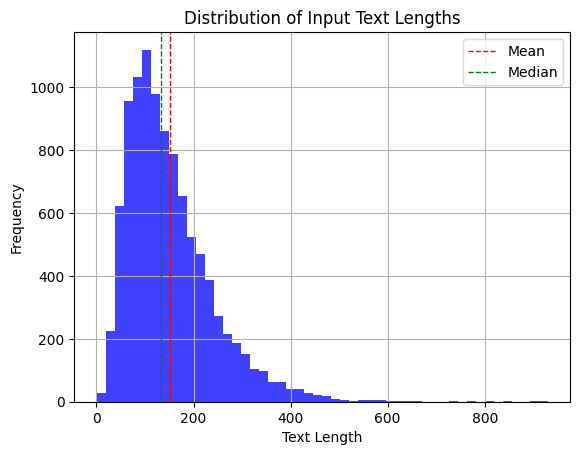

In [23]:
import matplotlib.pyplot as plt

text_lengths = [len(row) for row in raw_dataset["train"]["input_text"]]
max_length = max(text_lengths)
min_length = min(text_lengths)
mean_length = sum(text_lengths) / len(text_lengths)
median_length = sorted(text_lengths)[len(text_lengths) // 2]
percentile_95 = sorted(text_lengths)[int(0.95 * len(text_lengths))]

print(f"Max length: {max_length}")
print(f"Min length: {min_length}")
print(f"Mean length: {mean_length:.2f}")
print(f"Median length: {median_length}")
print(f"95th percentile: {percentile_95}")

plt.hist(text_lengths, bins=50, alpha=0.75, color="blue")
plt.axvline(mean_length, color="red", linestyle="dashed", linewidth=1, label="Mean")
plt.axvline(median_length, color="green", linestyle="dashed", linewidth=1, label="Median")
plt.title("Distribution of Input Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
from random import randrange
 
random_id = randrange(len(raw_dataset['train']))
raw_dataset['train'][random_id]

{'input_text': 'Wie haben Sie das Soziale gestärkt, wenn Sie ohne Genehmigung eine Selbstabfertigung zulassen, was dazu führt, dass das Personal auf dem Schiff, das schon die ganze Zeit mit dem Schiff gefahren ist, nun auch zusätzlich die Be- und Entladearbeiten ausführen soll?',
 'output_meta-llama_Llama-3.2-3B-Instruct': None,
 'output_meta-llama_Llama-3.1-8B-Instruct': None,
 'output_meta-llama_Llama-3.3-70B-Instruct': None,
 'flesch_reading_ease': 55.24,
 'smog_index': 0.0,
 'automated_readability_index': 24.6,
 'lexical_diversity': 0.8780487804878049,
 'syllable_count': 53,
 'complex_word_count': 7,
 'avg_word_length': 5.414634146341464,
 'sentence_length': 41,
 'flesch_kincaid_grade': 15.7,
 'coleman_liau_index': 14.0,
 'dale_chall_readability_score': 17.99,
 'linsear_write_formula': 23.5,
 'text_standard': '15th and 16th grade',
 'fernandez_huerta': 87.02,
 'szigriszt_pazos': 85.3,
 'gutierrez_polini': 29.98,
 'crawford': 2.4,
 'gulpease_index': 42.2,
 'osman': 25.89}

In [26]:
from transformers import AutoTokenizer
import numpy as np

model_id = "answerdotai/ModernBERT-base"
# model_id = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.model_max_length = 512

def tokenize(batch):
    tokenized = tokenizer(batch["input_text"], padding="max_length", truncation=True, return_tensors="np")
    return {"sentence_embeddings": tokenized["input_ids"]}

metrics_columns = [
    col for col in raw_dataset["train"].column_names
    if col not in ["input_text", "chosen_model"]  
]

def normalize_metrics(batch, columns):
    metrics = np.array([batch[col] for col in columns]).T
    return {"metrics": (metrics - metrics.mean(axis=0)) / (metrics.std(axis=0) + 1e-8)}

def combine_embeddings_and_metrics(batch):
    combined = np.concatenate([batch["sentence_embeddings"], batch["metrics"]], axis=1)
    return {"combined_features": combined}

tokenized_dataset = raw_dataset.map(tokenize, batched=True)
normalized_metrics = raw_dataset.map(lambda batch: normalize_metrics(batch, metrics_columns), batched=True)
final_dataset = tokenized_dataset.map(combine_embeddings_and_metrics, batched=True)

final_dataset = final_dataset.rename_column("chosen_model", "labels")

print(final_dataset["train"].features.keys())  
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask','lable'])

Map:   0%|                                                                             | 0/10000 [00:00<?, ? examples/s]


TypeError: can only concatenate str (not "NoneType") to str

In [14]:
from transformers import AutoModelForSequenceClassification
 
model_id = "answerdotai/ModernBERT-base"
# model_id = "google-bert/bert-base-uncased"
 
labels = tokenized_dataset["train"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=num_labels, label2id=label2id, id2label=id2label,
).to("cuda")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    f1 = f1_score(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)
    
    return {
        "f1": float(f1) if f1 == 1 else f1,
        "accuracy": float(accuracy)
    }

In [22]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


True

In [ ]:
wandb.init(
    project="modernbert-llm-router",
    name="experiment-1",
    config=training_args.to_dict(),
)

In [16]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments
 
# Define training args
training_args = TrainingArguments(
    output_dir="modernbert-llm-router",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    num_train_epochs=5,
    bf16=True,
    optim="sgd",
    # Logging & evaluation strategies
    logging_strategy="steps",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    # Log to Weights & Biases
    report_to="wandb",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_token=HfFolder.get_token(),
)
 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,1.571300,1.142964,0.811744
2,0.517900,0.452502,0.914325
3,0.247400,0.323521,0.924307
4,0.134000,0.280448,0.932018
5,0.072400,0.268199,0.933529


TrainOutput(global_step=1565, training_loss=0.75268801271725, metrics={'train_runtime': 2630.2723, 'train_samples_per_second': 19.015, 'train_steps_per_second': 0.595, 'total_flos': 1.31683609714944e+16, 'train_loss': 0.75268801271725, 'epoch': 5.0})

In [ ]:
wandb.finish()

In [18]:
tokenizer.save_pretrained("modernbert-llm-router")
trainer.create_model_card()
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/RZJournal/modernbert-llm-router/commit/a219858b2e425096dce5115ce4348f1f117b9f5c', commit_message='End of training', commit_description='', oid='a219858b2e425096dce5115ce4348f1f117b9f5c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/RZJournal/modernbert-llm-router', endpoint='https://huggingface.co', repo_type='model', repo_id='RZJournal/modernbert-llm-router'), pr_revision=None, pr_num=None)

In [19]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="modernbert-llm-router", device=0)
 
sample = "How does the structure and function of plasmodesmata affect cell-to-cell communication and signaling in plant tissues, particularly in response to environmental stresses?"
 
pred = classifier(sample)
print(pred)

Device set to use cuda:0


[{'label': 'get_disposable_virtual_card', 'score': 0.15586267411708832}]
